In [1]:
import csoundengine as ce

In [2]:
from csoundengine.offline import OfflineEngine
e = OfflineEngine()

--Csound version 7.0 (double samples) Apr 22 2025
[commit: aaef34d3edf888cb46d6a8ba0e0b5a81d49db6a3]
libsndfile-1.2.2
sr = 44100.0, kr = 689.062, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
writing 1024-byte blks of shorts to /tmp/csoundengine-2nvwt3ai.wav (WAV)
SECTION 1:


In [3]:
e.compile(r'''
instr pitchtrackvoice
    isndtable, ifreqtable, iminfreq, imaxfreq, ifftsize, ihopfactor, iwinsizefactor, ifftoversample, imindb passign 4
	kfreq init 0.001
	kfreq0 init 0
	achannels[] = loscilx(1, 1, isndtable, 4, 1)
	a0 = achannels[0]
	iwinsize = ifftsize * iwinsizefactor
	ioverlap = int(iwinsize * ihopfactor)
	ifftsize2 = ifftsize * ifftoversample
	; a0d = delay(a0, ifftsize2 * iwinsizefactor * 0.5 / sr)
    a0d = a0
	a0anal = butlp(butlp(a0, imaxfreq * 7), imaxfreq*7)
	a0danal = butlp(butlp(a0d, imaxfreq * 7), imaxfreq * 7)
	afol = follow2(a0, 0.01, 0.1)
	kgate = schmitt(dbamp(rms(afol)), -30, -50) 
	fsig1 = pvsanal(a0danal, ifftsize, ioverlap, iwinsize, 0)
	fsigfeat = pvsanal(a0, ifftsize, ioverlap, iwinsize, 0)
	fsig2 = pvsanal(a0anal, ifftsize2, ioverlap, ifftsize2 * iwinsizefactor, 0)
	kfreq1, kamp1 pvspitch fsig1, ampdb(imindb) 
	kfreq2, kamp2 pvspitch fsig1, ampdb(imindb + 10)
	kfreq3, kamp3 pvspitch fsig2, ampdb(imindb + 5)
	
	kflatness = pvsflatness(fsigfeat, 50)
	kflatness = pow(kflatness, 1.5)
	kentropy0 pvsentropy fsigfeat, 50
	kentropy = bpf:k(kentropy0, 0, 0, 0.55, 0, 6, .15, 20, .5, 60, .9, 180, 1.)
	kpeakyness = pvsmagsumn(fsigfeat, 50, 50) / max(0.000000001, pvsmagsum(fsigfeat))
	kunpeakyness = 1 - kpeakyness
	knoisyness = sqrt(kflatness*kflatness + kentropy*kentropy + kunpeakyness*kunpeakyness)
	 
	kt = eventtime()
	kcount = eventcycles()
	ifreqtablesize = ftlen(ifreqtable)
	if kcount >= ifreqtablesize || detectsilence(a0, db(-90), 0.5) == 1 then
		turnoff
	endif
	kvalid1 = kfreq1 > iminfreq && kfreq1 < imaxfreq ? 1 : 0
	kvalid2 = kfreq2 > iminfreq && kfreq2 < imaxfreq ? 1 : 0
	kvalid3 = kfreq3 > iminfreq && kfreq3 < imaxfreq ? 1 : 0
	
	ksource = 1
	if kvalid1 == 0 && kvalid2 == 0 then
		kfreq1 = 0
	elseif kvalid1 == 1 && kvalid2 == 1 && abs(kfreq1 - kfreq2)/(kfreq1+kfreq2) > 0.1 then
		kfreq1pre = kfreq1
		kfreq1 = abs(kfreq1 - kfreq) < abs(kfreq2 - kfreq) ? kfreq1 : kfreq2
	elseif kvalid1 == 0 && kvalid2 == 1 then
		kfreq1 = kfreq2
	elseif kvalid1 == 1 && kvalid2 == 0 then
		kfreq1 = 0
		kvalid1 = 0
	endif
	
	if kvalid1 == 0 && kvalid3 == 1 && kfreq0 > 0 then
		if abs(kfreq3 - kfreq) / kfreq < 0.1 then
			ksource = 2
		endif
	elseif kvalid1 == 1 && kvalid3 == 1 && abs(kfreq1 - kfreq3) / kfreq > 0.25 then
		ksource = abs(kfreq1 - kfreq) < abs(kfreq3 - kfreq) ? 1 : 2
	endif
		
	kfreq0prev = kfreq0
	kfreq0 = ksource == 1 ? kfreq1 : kfreq3
	if kfreq0 > 10 then
		kfreq = kfreq0prev == 0 ? kfreq0 : mtof(lag(ftom(kfreq0), 0.01)) 
	endif
	kgate = kgate * (kfreq0 > 0 ? 1 : 0) * (knoisyness < 0.4 ? 1 : 0)
	kgate = max(trighold(kgate, 0.01), kgate)
	iatt = 0.02
	irel = 0.04
	aenv = lagud:a(interp(kgate), iatt, irel)
	aenv = lagud:a(aenv, iatt, irel)
	aenv = lagud:a(aenv, iatt, irel)
	asig = buzz(aenv, kfreq, 7, -1)
	
	outch 1, delay(a0, ifftsize / sr)
	outch 2, asig

    kidx = kcount*3 + 1
    tabw kfreq * kgate, kidx, ifreqtable
    tabw kt, kidx+1, ifreqtable
    tabw knoisyness, kidx+2, ifreqtable
	tabw kcount, 0, ifreqtable
endin
''')


In [4]:
# sndtab = e.readSoundfile("/home/em/Lib/snd/samples/speech/voiceover-fragment.flac")
sndtab = e.readSoundfile("/home/em/Lib/snd/samples/speech/finneganswake-fragm01.flac")
sndtabinfo = e.tableInfo(sndtab)
duration = sndtabinfo.duration
numcycles = int(duration * e.sr / e.ksmps)
freqtab = e.makeEmptyTable((numcycles + 100) * 3)
print(f"Duration: {sndtabinfo.duration:.3f}")

e.sched('pitchtrackvoice', 0, duration + 0.1, sndtab, freqtab, 60, 300, 1024, 1/4, 1, 2, -45)
e.perform()

# Now retrieve information
outarr = e.getTableData(freqtab)
datalen = int(outarr[0])
freqs = outarr[1:1+datalen*3:3]
times = outarr[2:1+datalen*3:3]
noises = outarr[3:1+datalen*3:3]

freqs[freqs==0] = float("nan")


Duration: 15.984


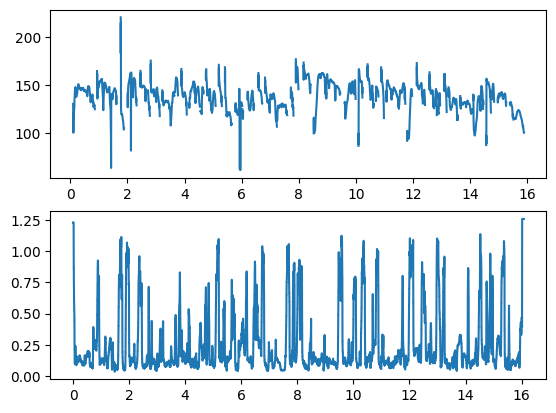

In [5]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1)
axs[0].plot(times, freqs)
axs[1].plot(times, noises)


resetting Csound instance
		   overall amps:  0.74716  1.00000
	   overall samples out of range:        0        0
0 errors in performance
512 1024 sample blks of shorts written to /tmp/csoundengine-2nvwt3ai.wav (WAV)


RenderJob(outfile='/tmp/csoundengine-2nvwt3ai.wav', samplerate=44100, encoding='float32', starttime=0.0, endtime=0.0, process=None)
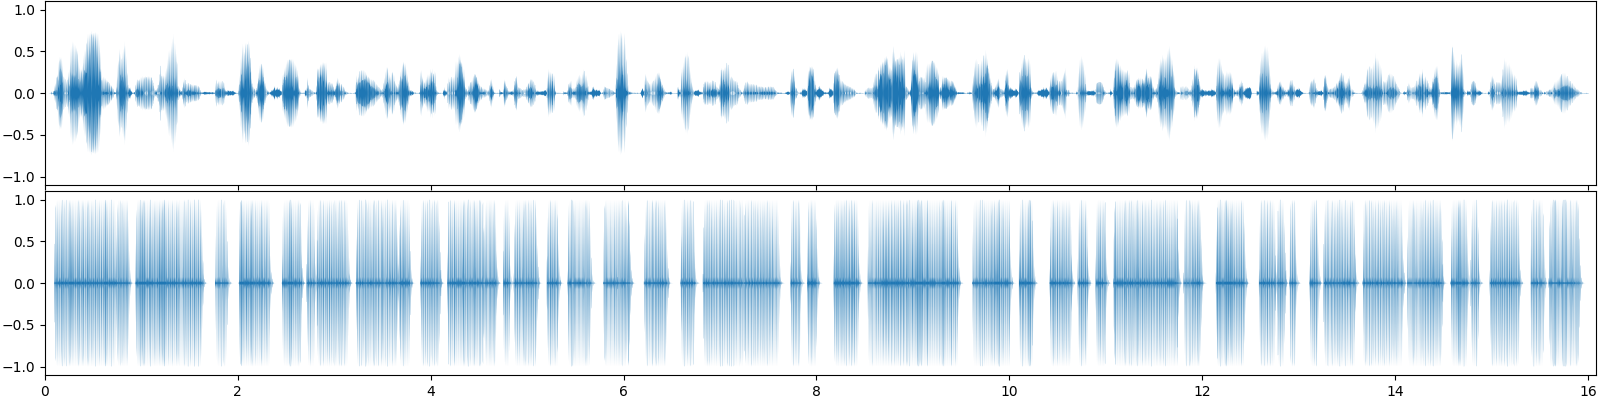

In [6]:
e.stop()